In [215]:
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
!nvidia-smi

Sat Mar 23 19:56:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.10              Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8              5W /  200W |   11933MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [217]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


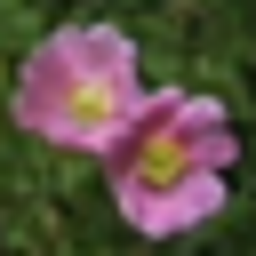

In [218]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [19, 35, 70]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

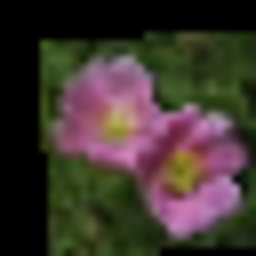

In [219]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p
        
     def __len__(self):
         return self.y.size(0)
        
     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2),
                    shear=5),
])

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

In [220]:
batch_size = 256
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe5905693c0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fe59056b5b0>}

In [221]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 3, stride=4),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),#nn.MaxPool2d(4),
            nn.Dropout2d(p=0.3),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

model = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       "cifar100_mobilenetv2_x0_5",
                       #'cifar100_resnet20',
                       pretrained=True)
model.to(device)
new_model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model
).to(device)
print(new_model(torch.rand(1, 32, 32, 3).to(device)))
summary(new_model, input_size=(32, 32, 3))
new_model

tensor([[-0.7019, -0.2515, -0.0283,  0.7045,  0.0588, -1.0393, -0.3102,  0.5475,
          0.1123,  0.8738,  0.6414,  0.8284, -0.4708, -0.3279,  0.3568,  0.1515,
         -0.2553, -0.3703,  0.9552,  0.6196, -0.2740,  0.3073, -0.0222, -0.3698,
         -0.1103,  0.6538,  0.3256, -0.2625, -0.4819,  1.2149, -0.8595, -0.0653,
          0.8394,  0.6689,  0.0092, -0.1670, -0.3483, -0.0948, -0.1278, -0.4549,
          0.9360,  0.3900,  0.9333, -0.1618,  1.0068,  0.9860,  0.9589, -0.9037,
         -0.4877, -0.5691,  0.7114,  0.6365, -1.7799, -0.9878, -0.3266,  0.6142,
         -0.6051,  0.3242, -1.1171, -0.1855, -0.7161, -0.4620,  0.2072,  0.5798,
          0.3876,  0.5768, -0.1102,  0.8221, -0.6510, -0.0477, -0.5689, -0.9516,
          1.0151,  0.4845,  0.2552,  0.8971, -0.9986,  0.4223,  1.1676,  0.2634,
          0.4795, -2.2087,  0.2083, -0.3158, -0.2930, -0.2444, -0.9191,  0.0140,
          0.2379, -0.2519, -0.2493,  0.4883, -0.2588, -0.0041, -1.4909, -0.8858,
          0.0621, -0.3151, -

Using cache found in /home/artyom/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Sequential(
  (0): Normalize()
  (1): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(8, 48, kernel_size=(1, 1

In [222]:
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             432
       BatchNorm2d-2         [-1, 16, 512, 512]              32
             ReLU6-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]             144
       BatchNorm2d-5         [-1, 16, 512, 512]              32
             ReLU6-6         [-1, 16, 512, 512]               0
            Conv2d-7          [-1, 8, 512, 512]             128
       BatchNorm2d-8          [-1, 8, 512, 512]              16
  InvertedResidual-9          [-1, 8, 512, 512]               0
           Conv2d-10         [-1, 48, 512, 512]             384
      BatchNorm2d-11         [-1, 48, 512, 512]              96
            ReLU6-12         [-1, 48, 512, 512]               0
           Conv2d-13         [-1, 48, 512, 512]             432
      BatchNorm2d-14         [-1, 48, 5

In [223]:
def compute_RF_numerical(net,img_np):
    '''
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks, it must be full of ones and with the correct
    shape.
    '''
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)
    #net.apply(weights_init)
    img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)
    out_cnn=net(img_.to(device))
    out_shape=out_cnn.size()
    ndims=len(out_cnn.size())
    grad=torch.zeros(out_cnn.size())
    l_tmp=[]
    for i in range(ndims):
        if i==0 or i ==1:#batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(out_shape[i]/2)
            
    grad[tuple(l_tmp)]=1
    out_cnn.backward(gradient=grad.to(device))
    grad_np=img_.grad[0,0].data.detach().cpu().numpy()
    idx_nonzeros=np.where(grad_np!=0)
    RF=[np.max(idx)-np.min(idx)+1 for idx in idx_nonzeros]
    
    return RF

compute_RF_numerical(model, np.zeros((1, 3, 1024, 1024)))

/tmp/ipykernel_10269/2592455981.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)


[1024, 1024]

In [224]:
## mobilenetv2
in_features = new_model[1].classifier[1].in_features
new_model[1].classifier[1] = nn.Linear(in_features=in_features,
                                      out_features=len(CLASSES),
                                      bias=True)
## resnet20
# in_features = new_model[1].fc.in_features
# new_model[1].fc = nn.Linear(in_features=in_features,
#                             out_features=len(CLASSES),
#                             bias=True)

new_model.to(device)
summary(new_model, input_size=(32, 32, 3))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
             ReLU6-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             144
       BatchNorm2d-6           [-1, 16, 32, 32]              32
             ReLU6-7           [-1, 16, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             128
       BatchNorm2d-9            [-1, 8, 32, 32]              16
 InvertedResidual-10            [-1, 8, 32, 32]               0
           Conv2d-11           [-1, 48, 32, 32]             384
      BatchNorm2d-12           [-1, 48, 32, 32]              96
            ReLU6-13           [-1, 48, 32, 32]               0
           Conv2d-14           [-1, 48,

In [225]:
keep_last = 158
total = len([*new_model.named_parameters()])
print("Всего параметров:", total)
print("Обучаемые параметры:")
params_to_update = []
for i, (name, param) in enumerate(new_model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False 
    else:
        params_to_update.append(param)
        param.requires_grad = True
        print("\t",name)
summary(new_model, input_size=(32, 32, 3))

Всего параметров: 158
Обучаемые параметры:
	 1.features.0.0.weight
	 1.features.0.1.weight
	 1.features.0.1.bias
	 1.features.1.conv.0.0.weight
	 1.features.1.conv.0.1.weight
	 1.features.1.conv.0.1.bias
	 1.features.1.conv.1.weight
	 1.features.1.conv.2.weight
	 1.features.1.conv.2.bias
	 1.features.2.conv.0.0.weight
	 1.features.2.conv.0.1.weight
	 1.features.2.conv.0.1.bias
	 1.features.2.conv.1.0.weight
	 1.features.2.conv.1.1.weight
	 1.features.2.conv.1.1.bias
	 1.features.2.conv.2.weight
	 1.features.2.conv.3.weight
	 1.features.2.conv.3.bias
	 1.features.3.conv.0.0.weight
	 1.features.3.conv.0.1.weight
	 1.features.3.conv.0.1.bias
	 1.features.3.conv.1.0.weight
	 1.features.3.conv.1.1.weight
	 1.features.3.conv.1.1.bias
	 1.features.3.conv.2.weight
	 1.features.3.conv.3.weight
	 1.features.3.conv.3.bias
	 1.features.4.conv.0.0.weight
	 1.features.4.conv.0.1.weight
	 1.features.4.conv.0.1.bias
	 1.features.4.conv.1.0.weight
	 1.features.4.conv.1.1.weight
	 1.features.4.conv.1.1.

In [226]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(params_to_update, lr=3e-4, momentum=0.9,
                      weight_decay=1e-5)
# добавляем постепенное уменьшение шага обучения каждые 20 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

Эпоха: 120
Лучшая доля правильных ответов: 98.046875
Текущая доля правильных ответов: 98.046875


  0%|          | 0/720 [00:00<?, ?it/s]

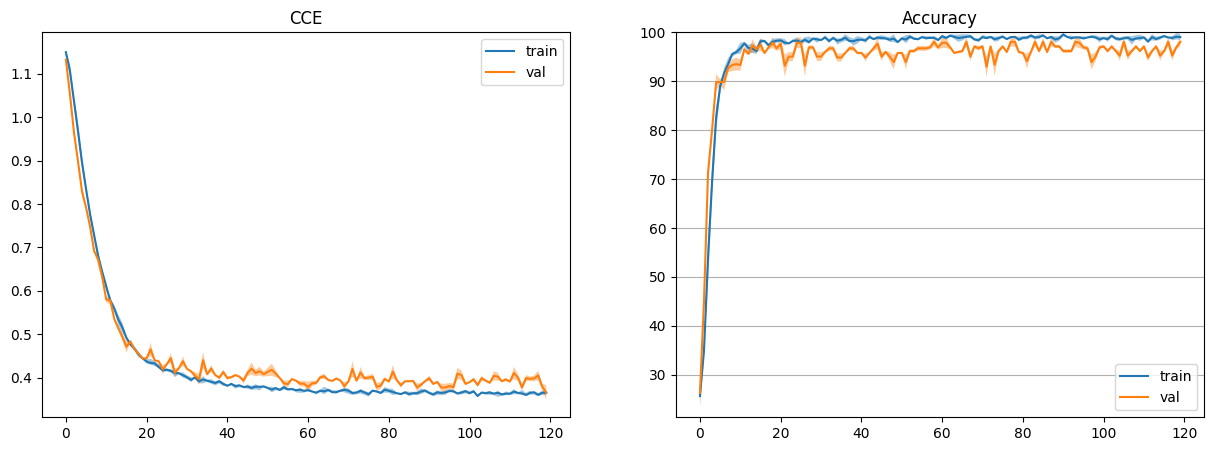

Обучение закончено за 388.47416520118713 секунд


In [227]:
EPOCHS = 120
REDRAW_EVERY = 10
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
checkpoint_path = 'cifar_cnn_fine.pth' 
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    new_model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    new_model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        torch.save(new_model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшая доля правильных ответов: %s\n'
          'Текущая доля правильных ответов: %s' % (epoch+1, best_acc, acc))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
new_model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

In [228]:
batch_size = 128
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform=None,
                           p=0.0) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  num_workers=2, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe57c3d09a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fe5905fc850>}

In [229]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          19     0.9960    0.9980    0.9970       500
          35     0.9960    0.9960    0.9960       500
          70     0.9980    0.9960    0.9970       500

    accuracy                         0.9967      1500
   macro avg     0.9967    0.9967    0.9967      1500
weighted avg     0.9967    0.9967    0.9967      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          19     0.9897    0.9600    0.9746       100
          35     0.9333    0.9800    0.9561       100
          70     0.9796    0.9600    0.9697       100

    accuracy                         0.9667       300
   macro avg     0.9675    0.9667    0.9668       300
weighted avg     0.9675    0.9667    0.9668       300

--------------------------------------------------


In [230]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_cnn_fine.pth'
torch.save(new_model.state_dict(), PATH)

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn_fine.pt'
torch.save(new_model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Sequential(
  (0): Normalize()
  (1): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(8, 48, kernel_size=(1, 1

In [231]:
class GlobalAvgPooling2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPooling2d, self).__init__()

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return torch.flatten(x, 1)

class MyModel(nn.Module):

    def __init__(self, model):
        super(MyModel, self).__init__()

        # Here you get the bottleneck/feature extractor
        self.normalization = model[0]
        self.resnet_feature_extractor = \
                nn.Sequential(*list(model[1].children())[:-1])

        # Now you can include your classifiers
        self.classifier = list(model[1].children())[-1]

    # Set your own forward pass
    def forward(self, x, extra_info=None):
        x = self.normalization(x)
        x = self.resnet_feature_extractor(x)
        x = self.classifier(x)
        return x

new_model = torch.load(PATH2)
new_model[1].avgpool = GlobalAvgPooling2d()
new_model.to(device)
model = MyModel(new_model).to(device)

summary(model, input_size=(32, 32, 3))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10240x4 and 1280x3)

In [ ]:
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN_MobileNet.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})

RuntimeError: mat1 and mat2 shapes cannot be multiplied (5120x4 and 1280x3)